In [ ]:
!pip install gensim torch numpy pandas nltk sklearn matplotlib datasets

In [2]:
import gensim.downloader
import pandas as pd
import numpy as np
import torch
import random
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
import datasets
import matplotlib.pyplot as plt
# enabling inline plots in Jupyter
%matplotlib inline
datasets.logging.set_verbosity_error()
import nltk
nltk.download('punkt')

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 1. Prepare the tweet_eval dataset similarly to the previous tutorial:

1. Load the train and validation data with the huggingface data loader. If your computer is struggling, use a subset of the training data.
2. Add any pre-processing and build the full list of the vocabulary in the training and validation data
3. Build the embedding matrix for the full vocabulary using Gensim's `glove-twitter-200` downloadable embedding (or `glove-twitter-25` if you find your computer is struggling). Remember to add the padding token.
4. Convert the tweets to vectors of embedding indices, with padding.
5. Pass the training data to PyTorch data class and data loader. Create a tensor for the validation data, as well as a tensor holding the validation labels.

In [3]:
# load the 3-class sentiment classification data from tweet_eval
train = datasets.load_dataset('tweet_eval', 'sentiment', split='train')
val = datasets.load_dataset('tweet_eval', 'sentiment', split='validation')

train_corpus = [x["text"] for x in train]
train_labels = [x["label"] for x in train]

val_corpus = [x["text"] for x in val]
val_labels = [x["label"] for x in val]

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


In [4]:
# creating the full list of vocabulary in the tweet_eval data
total_vocabulary = set()
for tweet in train_corpus + val_corpus:
    tokens = word_tokenize(tweet)
    for t in tokens:
        total_vocabulary.add(t.lower())
total_vocabulary = sorted(list(total_vocabulary))
# appending an empty token to 'save' the zero position for the padding token, and shift all the indices
total_vocabulary = [""]+total_vocabulary

In [5]:
# making sure that the embeddings are loaded
try:
    glove
except NameError:
    glove = gensim.downloader.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


In [6]:
def create_embedding_matrix_random(tokens, embedding):
    """a version of the embedding function that adds an extra zero vector at position 0
    and initializes missing tokens as random vectors"""
    size = embedding.vector_size
    # note the extra zero vector that will used for padding
    embedding_matrix=np.zeros((len(tokens),size))

    for i in range(1,len(tokens)):
        try:
            embedding_matrix[i]=embedding[tokens[i]]
        except KeyError: #to catch the words missing in the embeddings
            try:
                embedding_matrix[i]=embedding[tokens[i].lower()]
            except KeyError:
                embedding_matrix[i] = np.random.rand(size)
            embedding_matrix[i] = np.random.rand(size)
    return embedding_matrix
embedding_matrix = create_embedding_matrix_random(total_vocabulary, glove)

In [7]:
def text_to_indices(text, total_vocabulary):
    """turning the input text into a vector of indices in total_vocabulary that corresponds to the tokenized words in the input text"""
    encoded_text = []
    tokens = word_tokenize(text)
    for t in tokens:
        index = total_vocabulary.index(t.lower())
        encoded_text.append(index)
    return encoded_text

def add_padding(vector, max_length, padding_index):
    """adding the padding token to make the input vector the max_length size"""
    if len(vector) < max_length:
        vector.extend(padding_index for _ in range(max_length-len(vector)))
    return vector


In [8]:
# getting the feature vectors
train_features = [text_to_indices(x, total_vocabulary) for x in train_corpus]
val_features = [text_to_indices(x, total_vocabulary) for x in val_corpus]

longest_tweet = max(train_features+val_features, key=len)
max_length = len(longest_tweet)
padding_index = 0

# padding the feature vectors
train_features = [add_padding(x, max_length, padding_index) for x in train_features]
val_features = [add_padding(x, max_length, padding_index) for x in val_features]

In [9]:
class TweetEvalTrain(torch.utils.data.Dataset):
    # defining the sources of the data
    def __init__(self):
        self.X = torch.LongTensor(train_features)
        self.y = torch.from_numpy(np.array(train_labels))

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index].unsqueeze(0)
        return X, y

    def __len__(self):
        return len(self.y)

val_data = torch.LongTensor(val_features)
val_targets = torch.from_numpy(np.array(val_labels))

data_train = TweetEvalTrain()
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64)

# 2. Define the RNN model.

1. Create an RNN model with pre-trained embedding layer (initialized from the embedding matrix produced above, with trainable embeddings). The embedding layer should be followed by a bidirectional [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) layer, which in its turn is followed by a linear layer outputting the logits for 3 classes.
2. In the forward pass, the model should encode the input, retrieve the output of rnn and the final state from the rnn unit. , and run that state through the final linear layer.
3. **Optional, advanced**: implement a `rnn_type` parameter for the model which will control the type of RNN cell used: [vanilla RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) or [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html). If you try to implement the LSTM, note that its output is different from RNN and GRU cells, and adjust your output handling in the forward pass accordingly.
4. Try running the model (or all three types of models, if you implement (3)) with the same Adam optimizer and CrossEntropyLoss as before, training for 3 epochs.

In [10]:
# defining the simple FFN model + embedding layer

class SimpleRNN(torch.nn.Module):
    def __init__(self, rnn_size, n_classes, embedding_matrix):
        super().__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), padding_idx=0, freeze=False).float()
        emb_dim = embedding_matrix.shape[1]
        self.rnn = torch.nn.RNN(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        self.fc_logits = torch.nn.Linear(2*rnn_size, n_classes)

    def forward(self, inputs):
        # encode the input vectors
        encoded_inputs = self.embedding(inputs)

        # The RNNs return two tensors: one representing the outputs at all positions
        # of the final layer, and another representing the final states of each layer.
        # In this example, we'll use just the final states.
        # NB: for a bidirectional RNN, the final state corresponds to the *last* token
        # in the forward direction and the *first* token in the backward direction.
        rnn_out, final_state = self.rnn(encoded_inputs)
        top_rnn = torch.cat([final_state[-2], final_state[-1]], dim=1)
        # run the output through the final linear layer
        logits = self.fc_logits(top_rnn)
        return logits


In [11]:
# advanced version supporting multiple types of RNN layers

class SimpleRNN(torch.nn.Module):
    def __init__(self, rnn_size, n_classes, embedding_matrix, rnn_type="RNN"):
        super().__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), padding_idx=0, freeze=False).float()
        emb_dim = embedding_matrix.shape[1]
        # saving the rnn type to model attribute so that it would be available for the forward pass
        self.rnn_type = rnn_type
        if rnn_type == "RNN":
            self.rnn = torch.nn.RNN(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif rnn_type == "LSTM":
            self.rnn = torch.nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = torch.nn.GRU(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        else:
            raise LookupError("Only RNN, LSTM, GRU are supported.")
        self.fc_logits = torch.nn.Linear(2*rnn_size, n_classes)

    def forward(self, inputs):
        # encode the input vectors
        encoded_inputs = self.embedding(inputs)

        # The RNNs return two tensors: one representing the outputs at all positions
        # of the final layer, and another representing the final states of each layer.
        # In this example, we'll use just the final states.
        # NB: for a bidirectional RNN, the final state corresponds to the *last* token
        # in the forward direction and the *first* token in the backward direction.
        #print(encoded_inputs.shape)

        if self.rnn_type in ["GRU", "RNN"]:
            rnn_out, final_state = self.rnn(encoded_inputs)
        else:
            # LSTM's output is different and needs to be treated differently, see documentation for details
            rnn_out, (final_state, c_n) = self.rnn(encoded_inputs)
        top_rnn = torch.cat([final_state[-2], final_state[-1]], dim=1)
        # run the output through the final linear layer
        logits = self.fc_logits(top_rnn)
        return logits

In [12]:
# training loop
def training_loop(model, num_epochs):
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        losses = []
        for batch_index, (inputs, targets) in enumerate(train_loader):

            optimizer.zero_grad()
            outputs = model(inputs)
            targets = torch.flatten(targets)
            #print(outputs.shape, targets.shape)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f'Epoch {epoch+1}: loss {np.mean(losses)}')
    return model

def evaluate(model, val_labels):
    with torch.no_grad():

        # making predictions on the test set and evaluating the model
        outputs = model(val_data)
        vals, indices = torch.max(outputs, 1)
        predictions = indices.tolist()

    acc = accuracy_score(predictions, val_labels)
    print(f'Model accuracy: {acc}')
    return acc

In [13]:
# initializing and training the model:
# base version
#myRNN = SimpleRNN(rnn_size=100, n_classes=3, embedding_matrix=embedding_matrix)

# advanced version
myRNN = SimpleRNN(rnn_size=100, n_classes=3, embedding_matrix=embedding_matrix, rnn_type="LSTM")
myRNN = training_loop(myRNN, 3)
evaluate(myRNN, val_labels)

Epoch 1: loss 0.8125742581917227
Epoch 2: loss 0.6559482858441822
Epoch 3: loss 0.5483768118798816
Model accuracy: 0.6805


0.6805

# 3. Moving to GPUs!

1. Open your notebook in [Google Colaboratory](https://colab.research.google.com/) (you will need a google account for that.)
2. Modify your code so that the training would be happening on GPU. Hint: you need to make sure that both the model and the data are on the GPU, and you will need to enable GPU in Runtime > change runtime type in Colaboratory top menu.
3. Train your RNN model on the GPU. How much faster is it? Do you get exactly the same results when the same model is trained on CPU and on GPU?
4. **Optional, advanced:** modify your training and evaluation loop to save the training and validation loss across epochs. Train the model with all three types of recurrent cells and plot the learning curves across training epochs. A helper plotting function is provided.
5. Consider your plots. Which type of cell works the best? Is there a significant difference in training dynamics or overall performance?
6. **Even more optional and advanced:** experiment with different number of recurrent layers. If you have an RNN with more than one layer, you can add [dropout](https://adriangcoder.medium.com/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b): it's a type of regularization that is often used in multi-layer neural networks. It can be easily added in PyTorch recurrent cells as a layer parameter `dropout`, set to a float number indicating the percentage of neurons that should be "dropped" (0.5 by default). Repeat the experiment with all types of RNN cells, adding the dropout value 0.5 with 2 layers.

In [14]:
# define a global boolean variable for availability of GPU:
USE_GPU = False
if torch.cuda.is_available():
  USE_GPU = True
  print(f'using {torch.cuda.get_device_name(0)}')

In [15]:
# version of the Dataset class that uses GPU if available:

class TweetEvalTrain(torch.utils.data.Dataset):
    # defining the sources of the data
    def __init__(self):
        self.X = torch.LongTensor(train_features)
        self.y = torch.from_numpy(np.array(train_labels))
        # moving to cuda here
        if USE_GPU:
          self.X = self.X.cuda()
          self.y = self.y.cuda()

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index].unsqueeze(0)
        return X, y

    def __len__(self):
        return len(self.y)

val_data = torch.LongTensor(val_features)
# remember to also move the validation data!
if USE_GPU:
  val_data = val_data.cuda()

data_train = TweetEvalTrain()
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64)

In [16]:
# version of the training loop that uses GPU if available
# it also explicitly receives the data objects 
def training_loop(model, num_epochs, train_loader, val_data, val_targets):

    def train(model):
      # helper function for batch training
        losses = []
        for batch_index, (inputs, targets) in enumerate(train_loader):

            optimizer.zero_grad()
            outputs = model(inputs)
            targets = torch.flatten(targets)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        return (model, losses)

    def validate(model):
      # helper function for validating at a given stage of training
        with torch.no_grad():
            loss_function = torch.nn.CrossEntropyLoss()
            # making predictions on the validation set and saving the validation loss data
            outputs = model(val_data)
            targets = torch.flatten(val_targets)
            val_loss = loss_function(outputs, targets)
        return val_loss.item()

    # setting up a list to save loss data across epochs
    loss_data = []
    validation_data = []

    # moving the model to gpu
    if USE_GPU:
        model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = torch.nn.CrossEntropyLoss()
    
    # iterating over epochs
    for epoch in range(num_epochs):
        model, losses = train(model)
        loss_data.append(losses)
        validation_data.append(validate(model))
        print(f'Epoch {epoch+1}: training loss {round(np.mean(losses),3)}, validation loss {round(validation_data[-1], 3)}')
    # returning both the model itself (to be used for evaluation) and the losses across epoch
    return (model, loss_data, validation_data)

In [17]:
# initializing and training the model:

# base version
#myRNN = SimpleRNN(rnn_size=100, n_classes=3, embedding_matrix=embedding_matrix)

# advanced version
myRNN = SimpleRNN(rnn_size=100, n_classes=3, embedding_matrix=embedding_matrix, rnn_type="LSTM")
# picking up the model object back from the modified training loop
myRNN = training_loop(myRNN, 3, train_loader, val_data, val_targets)[0]
evaluate(myRNN, val_labels)

Epoch 1: training loss 0.816, validation loss 0.735
Epoch 2: training loss 0.66, validation loss 0.7
Epoch 3: training loss 0.553, validation loss 0.732
Model accuracy: 0.6845


0.6845

In [18]:
def plot_curve(train_scores, val_scores, model_name):
    """A helper function to plot the train scores and validation scores
    against the training epochs"""

    num_epochs = range(1, len(val_scores)+1)

    # Calculate the values to plot

    train_mean = [np.mean(x) for x in train_scores]
    train_std = [np.std(x) for x in train_scores]
    upper_curve = [train_mean[i]+train_std[i] for i in range(len(train_mean))]
    lower_curve = [train_mean[i]-train_std[i] for i in range(len(train_mean))]
    val_mean = val_scores

    # Plot the learning and cross-validation curve

    plt.rcParams['font.size'] = '16'
    fig, ax = plt.subplots( figsize=(10,6) )
    plt.ylim([0.0, 1.0])
    plt.plot(num_epochs, train_mean, color='red', marker='o', markersize=5, label='Training loss')
    plt.fill_between(num_epochs, upper_curve, lower_curve, alpha=0.15, color='red')
    plt.plot(num_epochs, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation loss')
    plt.title('Learning Curve for '+model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(loc='lower right')

In [19]:
# setting up the objects
myRNN = SimpleRNN(rnn_size=100, n_classes=3, embedding_matrix=embedding_matrix, rnn_type="RNN")
myGRU = SimpleRNN(rnn_size=100, n_classes=3, embedding_matrix=embedding_matrix, rnn_type="GRU")
myLSTM = SimpleRNN(rnn_size=100, n_classes=3, embedding_matrix=embedding_matrix, rnn_type="LSTM")

models = {"RNN":myRNN, "LSTM":myLSTM, "GRU":myGRU}



Training RNN-based model:
Epoch 1: training loss 0.878, validation loss 0.812
Epoch 2: training loss 0.787, validation loss 0.813
Epoch 3: training loss 0.772, validation loss 0.785
Epoch 4: training loss 0.658, validation loss 0.797
Epoch 5: training loss 0.623, validation loss 0.796
Model accuracy: 0.6735

Training LSTM-based model:
Epoch 1: training loss 0.813, validation loss 0.731
Epoch 2: training loss 0.657, validation loss 0.695
Epoch 3: training loss 0.547, validation loss 0.723
Epoch 4: training loss 0.433, validation loss 0.824
Epoch 5: training loss 0.334, validation loss 0.972
Model accuracy: 0.6535

Training GRU-based model:
Epoch 1: training loss 0.794, validation loss 0.713
Epoch 2: training loss 0.639, validation loss 0.692
Epoch 3: training loss 0.526, validation loss 0.739
Epoch 4: training loss 0.402, validation loss 0.865
Epoch 5: training loss 0.301, validation loss 1.077
Model accuracy: 0.645


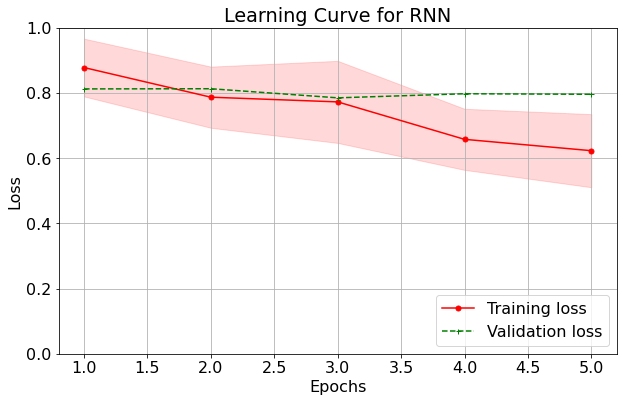

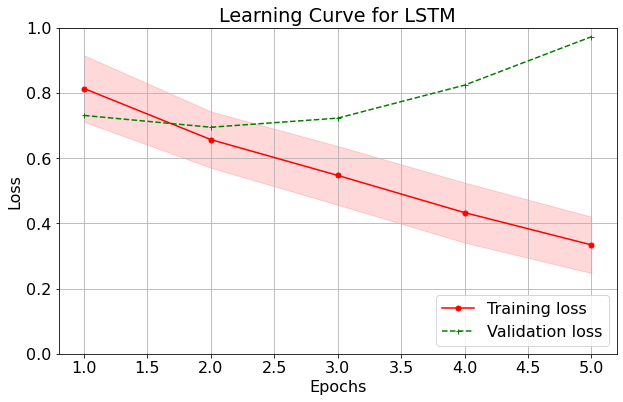

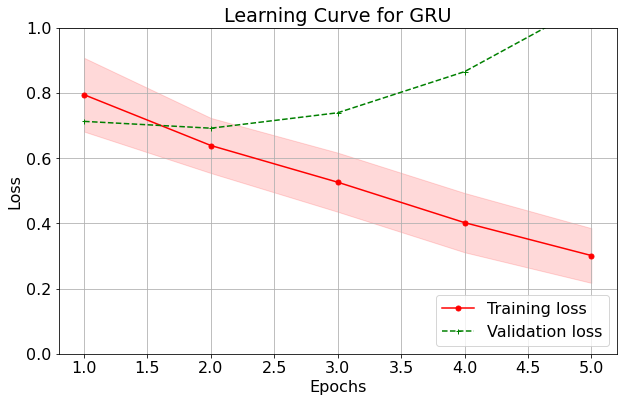

In [20]:
# train and evaluate all models
for m in models.keys():
    print(f"\nTraining {m}-based model:")
    model, loss_data, validation_data = training_loop(models[m], 5, train_loader, val_data, val_targets)
    evaluate(model, val_labels)
    plot_curve(loss_data, validation_data, m)

Verdict: In this case although RNN has higher accuracy, its training dynamics is quite static, whereas both GRU and LSTM learn more towards the end of training.

# Adding dropout (optional, advanced)

In [21]:
# advanced version supporting deep RNNs with dropout

class DeepRNNWithDropout(torch.nn.Module):
  # now at initialization we need to specify the number of layers and dropout. If number of layers is 1, PyTorch ignores the dropout setting.
    def __init__(self, rnn_size, n_classes, embedding_matrix, rnn_type="RNN", num_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), padding_idx=0, freeze=False).float()
        emb_dim = embedding_matrix.shape[1]
        # saving the rnn type to model attribute so that it would be available for the forward pass
        self.rnn_type = rnn_type
        if rnn_type == "RNN":
            self.rnn = torch.nn.RNN(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=num_layers, batch_first=True, dropout=dropout)
        elif rnn_type == "LSTM":
            self.rnn = torch.nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=num_layers, batch_first=True, dropout=dropout)
        elif rnn_type == "GRU":
            self.rnn = torch.nn.GRU(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=num_layers, batch_first=True, dropout=dropout)
        else:
            raise LookupError("Only RNN, LSTM, GRU are supported.")
        self.fc_logits = torch.nn.Linear(2*rnn_size, n_classes)

    def forward(self, inputs):
        # encode the input vectors
        encoded_inputs = self.embedding(inputs)

        if self.rnn_type in ["GRU", "RNN"]:
            rnn_out, final_state = self.rnn(encoded_inputs)
        else:
            # LSTM's output is different and needs to be treated differently, see documentation for details
            rnn_out, (final_state, c_n) = self.rnn(encoded_inputs)
        top_rnn = torch.cat([final_state[-2], final_state[-1]], dim=1)
        # run the output through the final linear layer
        logits = self.fc_logits(top_rnn)
        return logits


Training RNN-based model:
Epoch 1: training loss 0.89, validation loss 0.998
Epoch 2: training loss 0.912, validation loss 0.842
Epoch 3: training loss 0.783, validation loss 0.821
Epoch 4: training loss 0.685, validation loss 0.783
Epoch 5: training loss 0.631, validation loss 0.806
Model accuracy: 0.636

Training LSTM-based model:
Epoch 1: training loss 0.806, validation loss 0.735
Epoch 2: training loss 0.659, validation loss 0.7
Epoch 3: training loss 0.557, validation loss 0.73
Epoch 4: training loss 0.446, validation loss 0.818
Epoch 5: training loss 0.349, validation loss 0.953
Model accuracy: 0.646

Training GRU-based model:
Epoch 1: training loss 0.782, validation loss 0.713
Epoch 2: training loss 0.641, validation loss 0.698
Epoch 3: training loss 0.532, validation loss 0.754
Epoch 4: training loss 0.409, validation loss 0.887
Epoch 5: training loss 0.307, validation loss 1.085
Model accuracy: 0.646


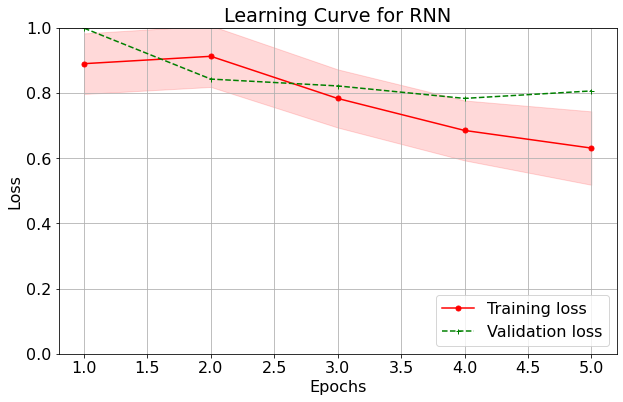

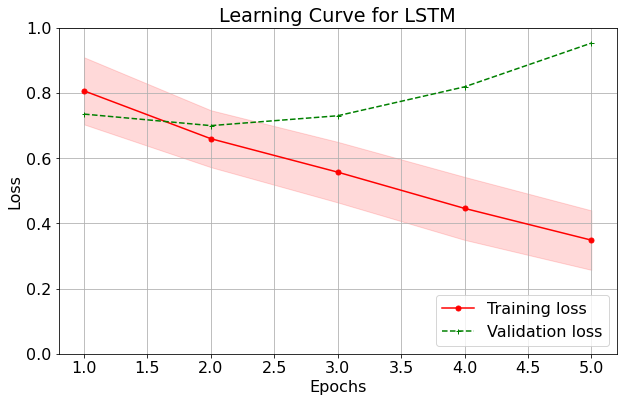

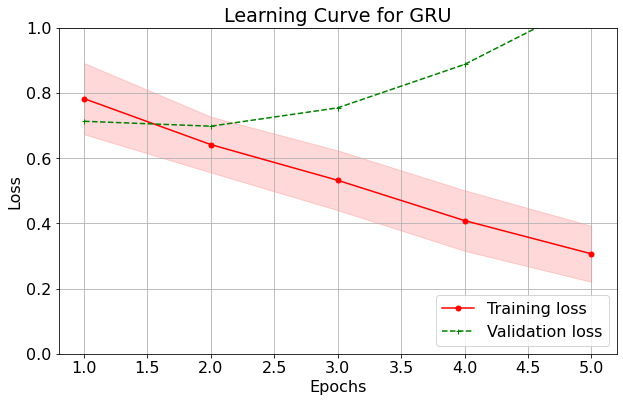

In [22]:
# setting up the objects
myRNN = DeepRNNWithDropout(rnn_size=100, n_classes=3, embedding_matrix=embedding_matrix, rnn_type="RNN", num_layers=2, dropout=0.5)
myGRU = DeepRNNWithDropout(rnn_size=100, n_classes=3, embedding_matrix=embedding_matrix, rnn_type="GRU", num_layers=2, dropout=0.5)
myLSTM = DeepRNNWithDropout(rnn_size=100, n_classes=3, embedding_matrix=embedding_matrix, rnn_type="LSTM", num_layers=2, dropout=0.5)

models = {"RNN":myRNN, "LSTM":myLSTM, "GRU":myGRU}

for m in models.keys():
    print(f"\nTraining {m}-based model:")
    model, loss_data, validation_data = training_loop(models[m], 5, train_loader, val_data, val_targets)
    evaluate(model, val_labels)
    plot_curve(loss_data, validation_data, m)

The deeper models with dropout still exhibit training dynamics similar to their original 1-layer non-regularized versions. Hyperparameter search (including also the hidden layer size) would be needed to find a more successful architecture.